In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Load Profiles

Notes:

l1_p , l2_p , l3_p : mean power in W. To obtain total energy in Wh consumed during the interval (depends on the granularity):

 - Energy = (l1_p + l2_p + l3_p) / granularity 

Depending on the usage and displayed data, the power of the 3 phases ( l1_p , l2_p , l3_p ) need to be added to form a single value.

In [3]:
day1 = '5fe3412c923d596335e69d4c-20210808-v0.0.1_SE05000139_Kaeltemaschine.csv' ## Sunday
day2 = '5fe3412c923d596335e69d4c-20210809-v0.0.1_SE05000139_Kaeltemaschine.csv' ## Monday
day3 = '5fe3412c923d596335e69d4c-20210810-v0.0.1_SE05000139_Kaeltemaschine.csv' ## Tuesday
day1 = pd.read_csv('/Users/wastechs/Documents/data/Kaeltemaschine/{}'.format(day1))
day2 = pd.read_csv('/Users/wastechs/Documents/data/Kaeltemaschine/{}'.format(day2))
day3 = pd.read_csv('/Users/wastechs/Documents/data/Kaeltemaschine/{}'.format(day3))

In [4]:
day1.head()

,t,L,V,I,S,P,Q,PF,PHI
0,1.628374e+09,1.0,238.921,31.026,7411.529,4752.550,5675.528,0.642,120.0
1,1.628374e+09,2.0,239.071,29.281,6998.035,4515.562,5331.538,0.647,120.0
2,1.628374e+09,3.0,240.536,30.406,7315.965,4822.356,5482.820,0.659,120.0
3,1.628374e+09,1.0,238.920,30.994,7403.923,4749.859,5656.511,0.642,120.0
4,1.628374e+09,2.0,239.067,29.265,6994.562,4522.702,5318.453,0.647,120.0


In [5]:
def epoch_convert(df):
    df.t = pd.to_datetime(df.t, unit='s')
    df.set_index(df.t, inplace=True)
    del df['t']
    return df

In [6]:
day1 = epoch_convert(day1)
day2 = epoch_convert(day2)
day3 = epoch_convert(day3)

In [7]:
day1.shape, day2.shape, day3.shape

((3101193, 8), (3101067, 8), (3101172, 8))

In [8]:
day1.index.min(), day1.index.max(), day2.index.min(), day2.index.max(), day3.index.min(), day3.index.max()

(Timestamp('2021-08-07 21:59:00.200999975'),
 Timestamp('2021-08-08 21:59:00.029000044'),
 Timestamp('2021-08-08 21:59:00.222000122'),
 Timestamp('2021-08-09 21:59:00.071000099'),
 Timestamp('2021-08-09 21:59:00.207999945'),
 Timestamp('2021-08-10 21:59:00'))

In [9]:
day1.head(6)

,L,V,I,S,P,Q,PF,PHI
t,,,,,,,,
2021-08-07 21:59:00.200999975,1.0,238.921,31.026,7411.529,4752.550,5675.528,0.642,120.0
2021-08-07 21:59:00.200999975,2.0,239.071,29.281,6998.035,4515.562,5331.538,0.647,120.0
2021-08-07 21:59:00.200999975,3.0,240.536,30.406,7315.965,4822.356,5482.820,0.659,120.0
2021-08-07 21:59:00.282999992,1.0,238.920,30.994,7403.923,4749.859,5656.511,0.642,120.0
2021-08-07 21:59:00.282999992,2.0,239.067,29.265,6994.562,4522.702,5318.453,0.647,120.0
2021-08-07 21:59:00.282999992,3.0,240.535,30.367,7306.766,4813.376,5463.419,0.659,120.0


In [10]:
day1.index[3] - day1.index[0]

Timedelta('0 days 00:00:00.082000017')

In [13]:
def kwatt(df):
    average = pd.DataFrame(df[['P', 'I', 'V', 'PF']].groupby(df.index).mean())
    average['kW'] = (average['V'] * average['I'] * average['PF'] * np.sqrt(3)) / 1000

    return average

In [14]:
day1_kw = kwatt(day1)
day2_kw = kwatt(day2)
day3_kw = kwatt(day3)

In [16]:
def decompose_phases(df):
    df_1 = df[df.L == 1.0]
    df_2 = df[df.L == 2.0]
    df_3 = df[df.L == 3.0]

    return df_1, df_2, df_3

In [17]:
day1_phase1, day1_phase2, day1_phase3 = decompose_phases(day1)
day2_phase1, day2_phase2, day2_phase3 = decompose_phases(day2)
day3_phase1, day3_phase2, day3_phase3 = decompose_phases(day3)

In [20]:
def load_plotter(df, feat, resample=None):
    
    if resample != None:
        plt.figure(figsize=(16, 6))
        plt.plot(df.resample(resample).sum().index, df[feat].resample(resample).sum())
        plt.title('Kaeltemaschine')
        plt.xlabel('Time = M-d-H')
        plt.ylabel('Power')
        plt.show()

    else:
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df[feat])
        plt.title('Kaeltemaschine')
        plt.xlabel('Time = M-d-H')
        plt.ylabel('{}'.format(feat))
        plt.show()

### Original Resolution

Tuesday:
- Idle / standby mode seems to be occuring from 21:00 until about 7:00
- Normal operations from 7:00 until 19:00 and standby mode again until 7:00
- Three peaks occuring around mid-day and in the afteroon are worth investigating
    - It would be interesting to know what Gassmann was doing in/with the fridge during these time periods?
    - Moving products inside, taking products out. . .

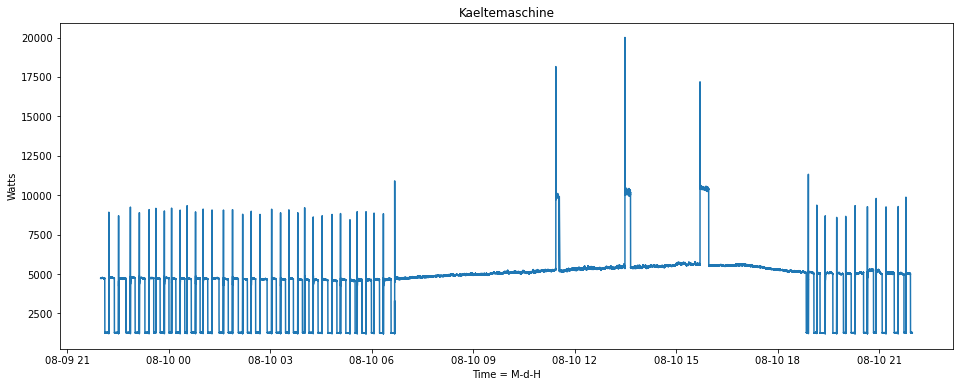

In [19]:
load_plotter(day3_phase1, 'P')

Monday:
- Idle / standby mode seems to be occuring from 21:00 until about 8:00
- Normal operations from 8:00 until 19:00 and standby mode again until 7:00
- The difference with this load profile is there are no peaks occuring. Rather a steady state "normal" operation mode throughout the business hours with a slight linear trend until noon and then a slight linear decreasing trend until ~17:00

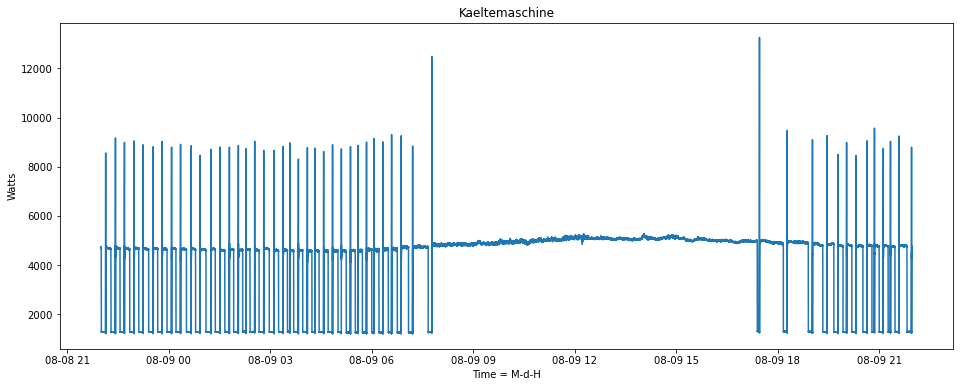

In [20]:
load_plotter(day2_phase1, 'P')

Sunday:
 - Idle / standby mode seems to be occuring for the majority of the day with cycling periods
 - Power consumption increases slightly throughout the day until about ~13:00 and then decreases
    - Possibly due to increasing ambient temperatures?

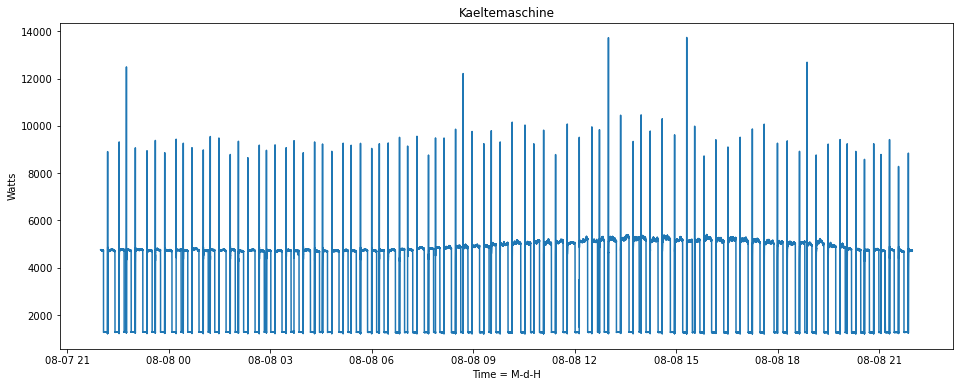

In [21]:
load_plotter(day1_phase1, 'P')

Investigating Monday idle mode:
 - How long do these peaks last?

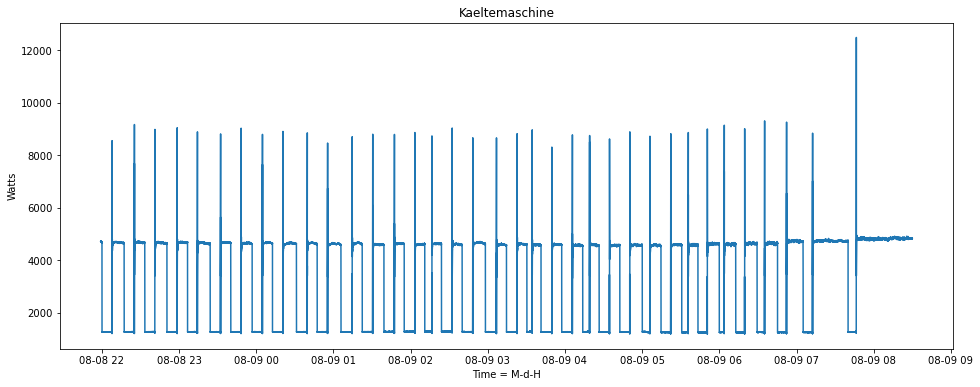

In [22]:
# Idle mode for Monday
load_plotter(day2_phase1['2021-08-08 21:59': '2021-08-09 8:30:00'], 'P')

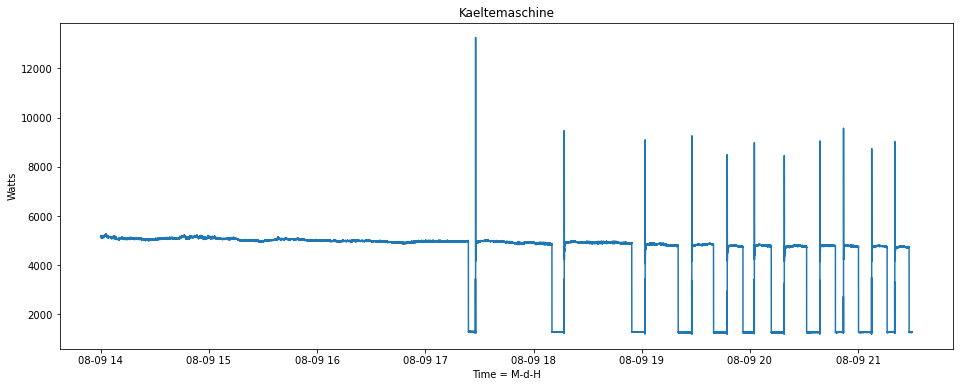

In [30]:
load_plotter(day2_phase1['2021-08-09 14:00:00': '2021-08-09 21:30:00'], 'P')

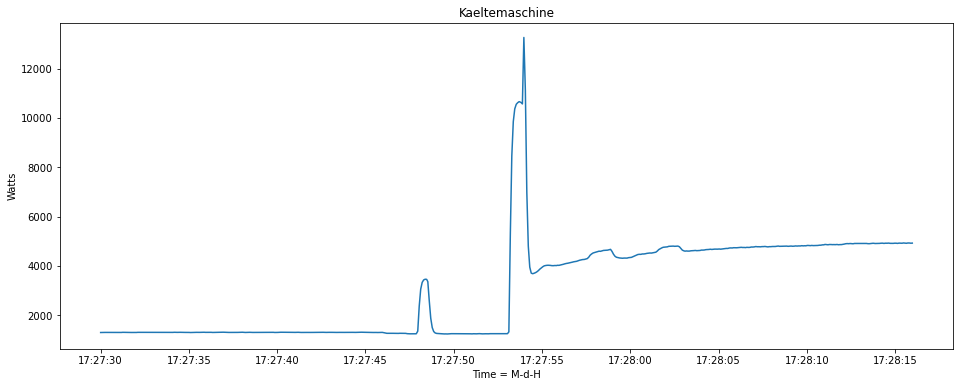

In [25]:
# What's signal and what's noise here?
load_plotter(day2_phase1['2021-08-09 17:27:30': '2021-08-09 17:28:15'], 'P')

Investigating the first peak on Tuesday:

- What's signal and what's noise here?
    - After the initial jump, consumption falls down to a consistent level for ~5 minutes and then falls down to "normal" operating hour levels again

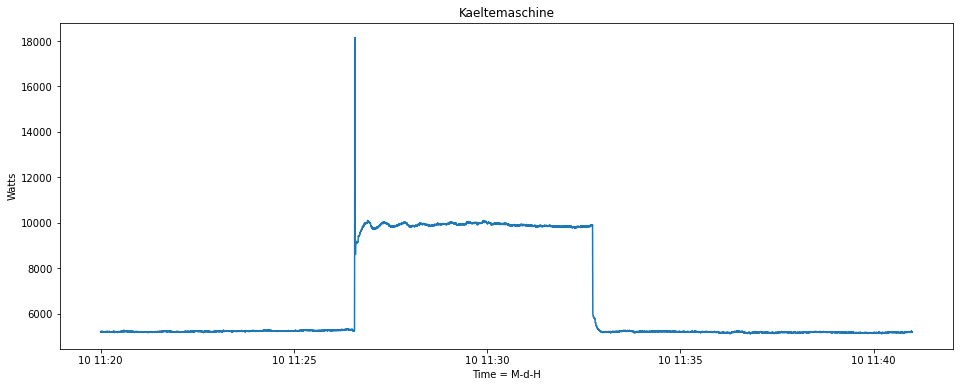

In [29]:
load_plotter(day3_phase1['2021-08-10 11:20': '2021-08-10 11:40'], 'P')

## 15 minute Resolution

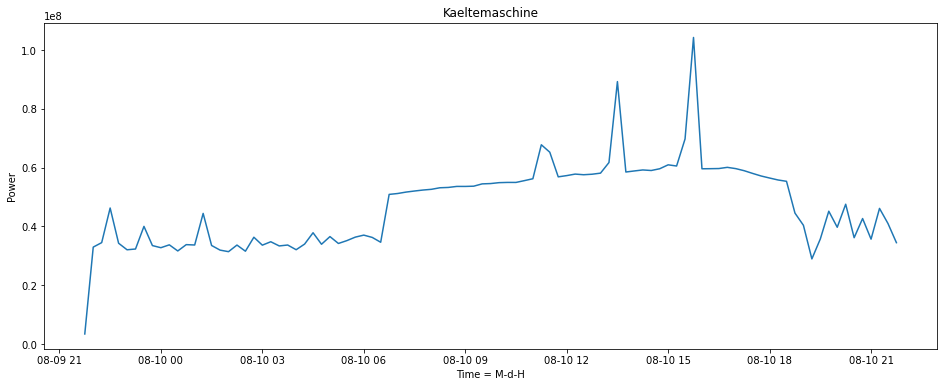

In [31]:
load_plotter(day3_phase1, 'P', '15T')

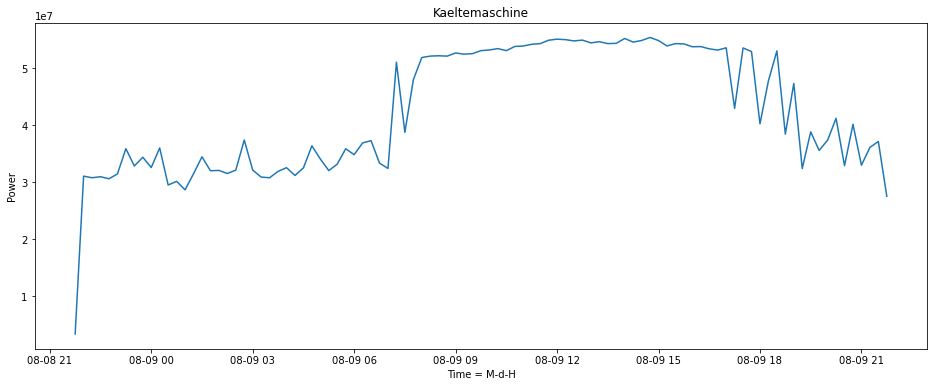

In [33]:
load_plotter(day2_phase1, 'P', '15T')

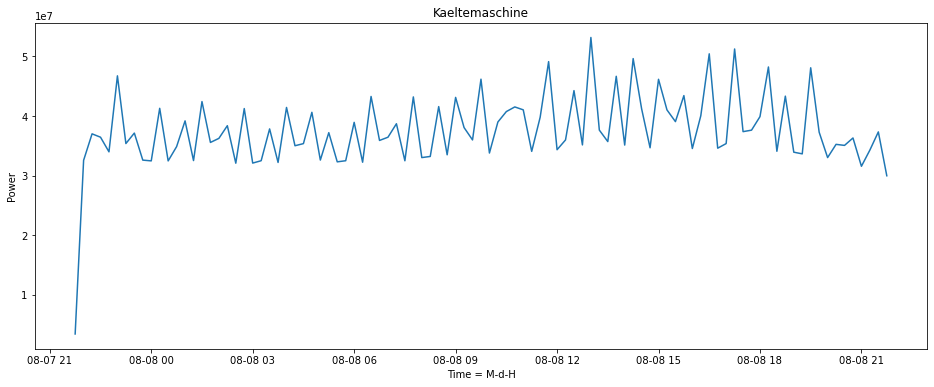

In [32]:
load_plotter(day1_phase1, 'P', '15T')

<AxesSubplot:xlabel='P', ylabel='Density'>

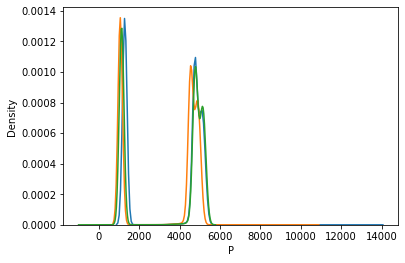

In [23]:
sns.kdeplot(day1_phase1.P)
sns.kdeplot(day1_phase2.P)
sns.kdeplot(day1_phase3.P)